In [21]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve,
    auc, precision_recall_curve
)
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [22]:
# 📥 Load and preprocess NSL-KDD
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels", "difficulty_degree"
]

train_df = pd.read_csv("data/KDDTrain+.txt", names=columns)
test_df = pd.read_csv("data/KDDTest+.txt", names=columns)

train_df.drop("difficulty_degree", axis=1, inplace=True)
test_df.drop("difficulty_degree", axis=1, inplace=True)

for col in ["protocol_type", "service", "flag"]:
    train_df[col] = train_df[col].astype("category").cat.codes
    test_df[col] = test_df[col].astype("category").cat.codes

train_df["labels"] = train_df["labels"].apply(lambda x: 1 if x == "normal" else 0)
test_df["labels"] = test_df["labels"].apply(lambda x: 1 if x == "normal" else 0)

X_train_full = train_df.drop("labels", axis=1)
y_train_full = train_df["labels"]
X_test = test_df.drop("labels", axis=1)
y_test = test_df["labels"]

scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)

def to_tensor_dataset(X, y):
    return TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32))

train_dataset = to_tensor_dataset(X_train, y_train)
val_dataset = to_tensor_dataset(X_val, y_val)
test_dataset = to_tensor_dataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [23]:
# 🧠 CNN-Only Architectures
class ShallowCNN(nn.Module):
    def __init__(self, input_dim):
        super(ShallowCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(16 * input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dim
        x = self.cnn(x)
        return self.fc(x).squeeze()

class DeepCNN(nn.Module):
    def __init__(self, input_dim):
        super(DeepCNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )
        self.fc = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn(x)
        return self.fc(x).squeeze()


In [24]:
import tempfile

def train_model(model, train_loader, epochs=10, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")
    train_time = time.time() - start_time
    return model, train_time

def evaluate_model(model, loader, name="Model"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    preds, probs, labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            output = model(xb).cpu().numpy().flatten()
            probs.extend(output)
            preds.extend(output > 0.5)
            labels.extend(yb.numpy())
    print(f"\n=== {name} Classification Report ===")
    print(classification_report(labels, preds))

    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} – Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(labels, probs)
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{name} – ROC Curve")
    plt.legend()
    plt.show()

    prec, rec, _ = precision_recall_curve(labels, probs)
    plt.plot(rec, prec, label=name)
    plt.title(f"{name} – Precision-Recall Curve")
    plt.legend()
    plt.show()

    return labels, preds, probs

In [25]:
# 🔁 LSTM-Only Architectures
class ShallowLSTM(nn.Module):
    def __init__(self, input_dim):
        super(ShallowLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=32, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, input_dim)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1]).squeeze()

class DeepLSTM(nn.Module):
    def __init__(self, input_dim):
        super(DeepLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=64, num_layers=2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1]).squeeze()


In [26]:
# 🔗 Hybrid CNN + LSTM Architectures
class ShallowHybrid(nn.Module):
    def __init__(self, input_dim):
        super(ShallowHybrid, self).__init__()
        self.cnn = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(input_size=16, hidden_size=32, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, D)
        x = self.cnn(x)     # (B, 16, D)
        x = x.permute(0, 2, 1)  # (B, D, 16)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1]).squeeze()

class DeepHybrid(nn.Module):
    def __init__(self, input_dim):
        super(DeepHybrid, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, num_layers=2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, D)
        x = self.cnn(x)     # (B, 64, D)
        x = x.permute(0, 2, 1)  # (B, D, 64)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1]).squeeze()


In [27]:
# 🔧 Training and Validation Loop with Time & Memory Tracking
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")
    end_time = time.time()

    # Validation Accuracy
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            preds_cls = (preds > 0.5).float()
            correct += (preds_cls == yb).sum().item()
            total += yb.size(0)

    print(f"Validation Accuracy: {correct / total:.4f}")
    print(f"Training Time: {end_time - start_time:.2f} seconds")
    return model, end_time - start_time


In [28]:
# 🚂 Train all models and track training time
input_dim = X_train.shape[1]
trained_models = {}
training_times = {}

models = {
    "ShallowCNN": ShallowCNN(input_dim),
    "DeepCNN": DeepCNN(input_dim),
    "ShallowLSTM": ShallowLSTM(input_dim),
    "DeepLSTM": DeepLSTM(input_dim),
    "ShallowHybrid": ShallowHybrid(input_dim),
    "DeepHybrid": DeepHybrid(input_dim)
}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    trained, t_time = train_model(model, train_loader, val_loader, epochs=10)
    trained_models[name] = trained
    training_times[name] = t_time



--- Training ShallowCNN ---
Epoch 1/10, Loss: 0.1155
Epoch 2/10, Loss: 0.0714
Epoch 3/10, Loss: 0.0633
Epoch 4/10, Loss: 0.0610
Epoch 5/10, Loss: 0.0555
Epoch 6/10, Loss: 0.0529
Epoch 7/10, Loss: 0.0524
Epoch 8/10, Loss: 0.0515
Epoch 9/10, Loss: 0.0540
Epoch 10/10, Loss: 0.0501
Validation Accuracy: 0.9859
Training Time: 17.77 seconds

--- Training DeepCNN ---
Epoch 1/10, Loss: 0.2716
Epoch 2/10, Loss: 0.1497
Epoch 3/10, Loss: 0.1218
Epoch 4/10, Loss: 0.1072
Epoch 5/10, Loss: 0.0977
Epoch 6/10, Loss: 0.0908
Epoch 7/10, Loss: 0.0874
Epoch 8/10, Loss: 0.0833
Epoch 9/10, Loss: 0.0799
Epoch 10/10, Loss: 0.0783
Validation Accuracy: 0.9731
Training Time: 21.36 seconds

--- Training ShallowLSTM ---
Epoch 1/10, Loss: 0.1117
Epoch 2/10, Loss: 0.0350
Epoch 3/10, Loss: 0.0266
Epoch 4/10, Loss: 0.0231
Epoch 5/10, Loss: 0.0208
Epoch 6/10, Loss: 0.0192
Epoch 7/10, Loss: 0.0178
Epoch 8/10, Loss: 0.0167
Epoch 9/10, Loss: 0.0159
Epoch 10/10, Loss: 0.0151
Validation Accuracy: 0.9955
Training Time: 23.39


📌 ShallowCNN Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.65      0.77     12833
         1.0       0.67      0.96      0.79      9711

    accuracy                           0.78     22544
   macro avg       0.81      0.80      0.78     22544
weighted avg       0.83      0.78      0.78     22544



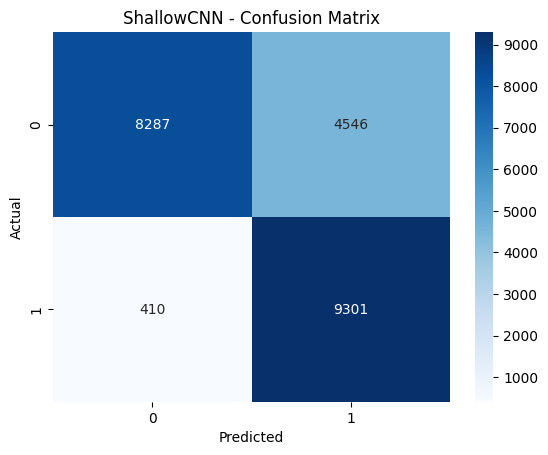

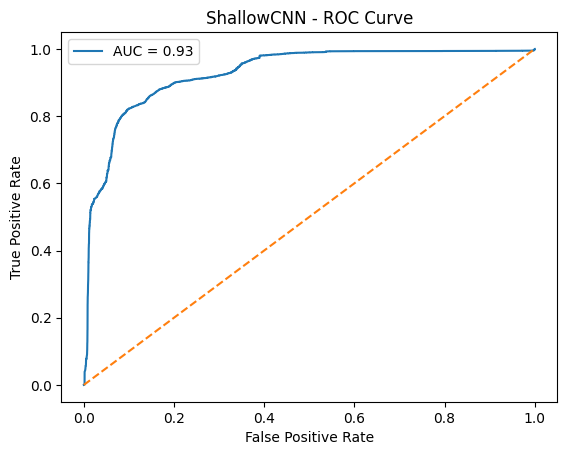

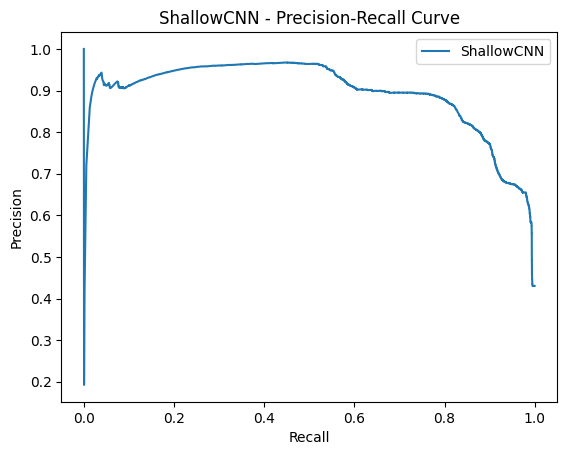


📌 DeepCNN Classification Report:

              precision    recall  f1-score   support

         0.0       0.93      0.65      0.76     12833
         1.0       0.67      0.93      0.78      9711

    accuracy                           0.77     22544
   macro avg       0.80      0.79      0.77     22544
weighted avg       0.82      0.77      0.77     22544



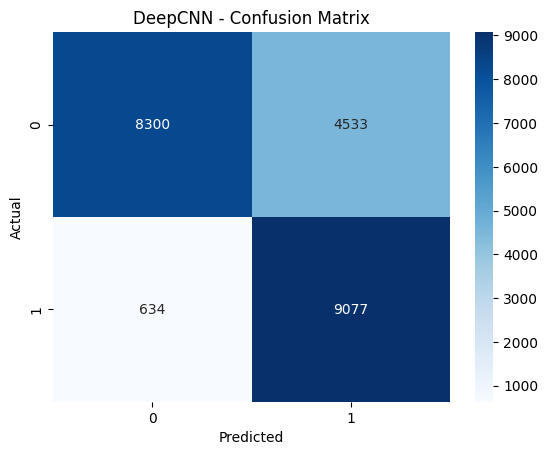

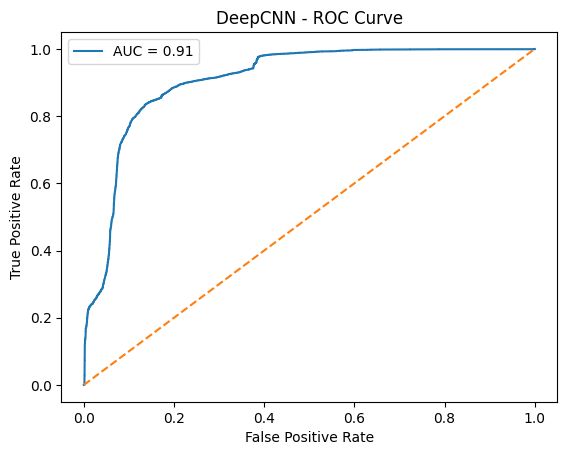

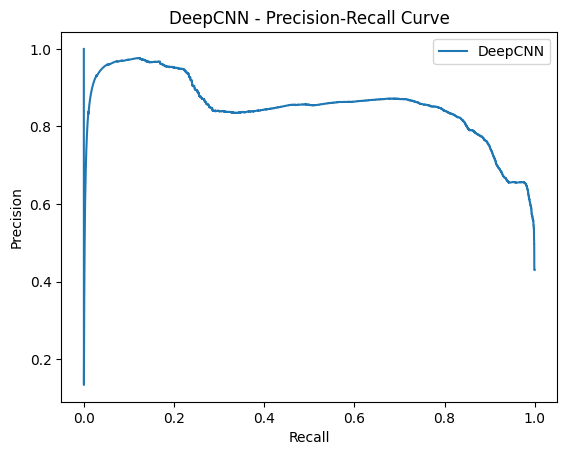


📌 ShallowLSTM Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.64      0.77     12833
         1.0       0.67      0.98      0.80      9711

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.79      0.78     22544



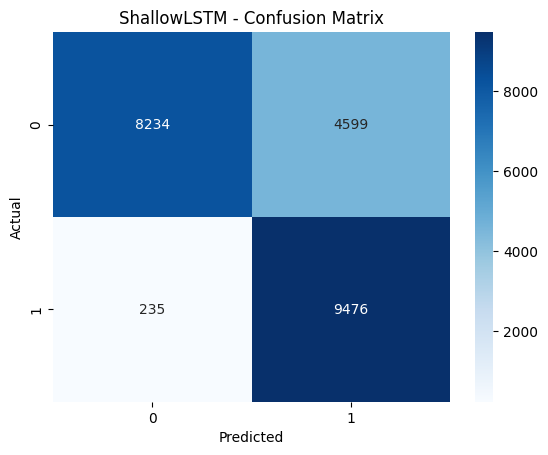

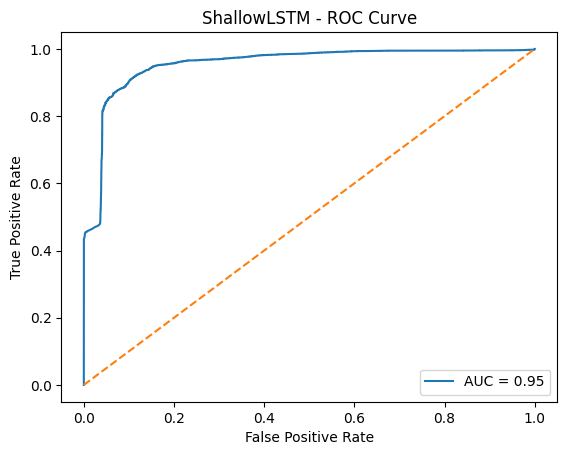

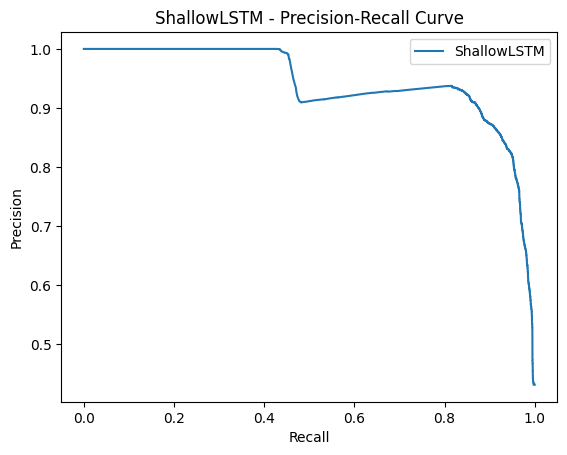


📌 DeepLSTM Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.62      0.76     12833
         1.0       0.66      0.98      0.79      9711

    accuracy                           0.78     22544
   macro avg       0.82      0.80      0.78     22544
weighted avg       0.84      0.78      0.77     22544



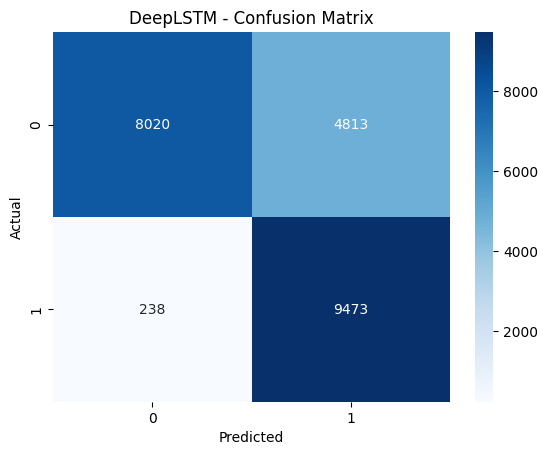

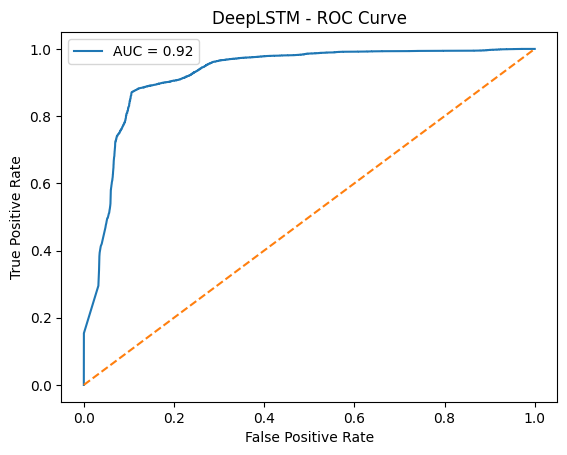

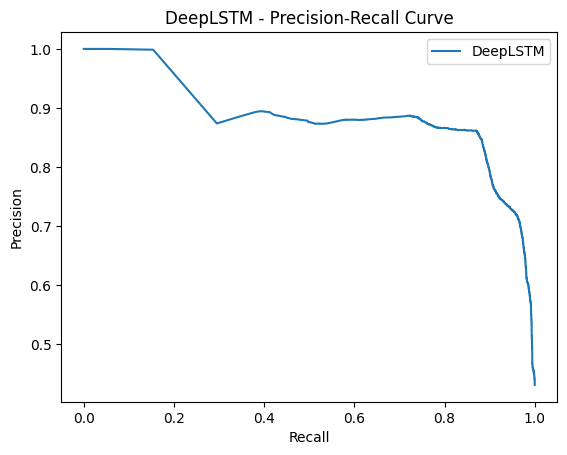


📌 ShallowHybrid Classification Report:

              precision    recall  f1-score   support

         0.0       0.98      0.65      0.78     12833
         1.0       0.68      0.98      0.80      9711

    accuracy                           0.79     22544
   macro avg       0.83      0.82      0.79     22544
weighted avg       0.85      0.79      0.79     22544



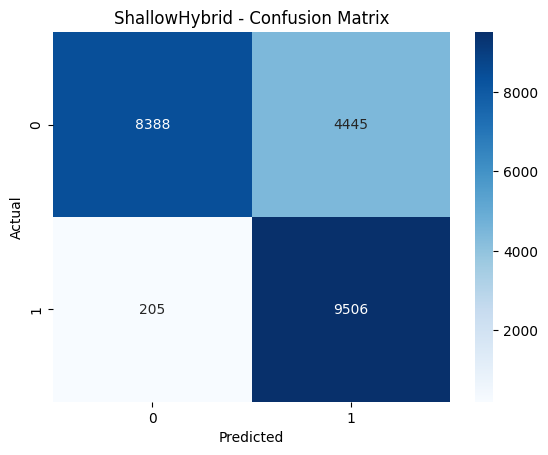

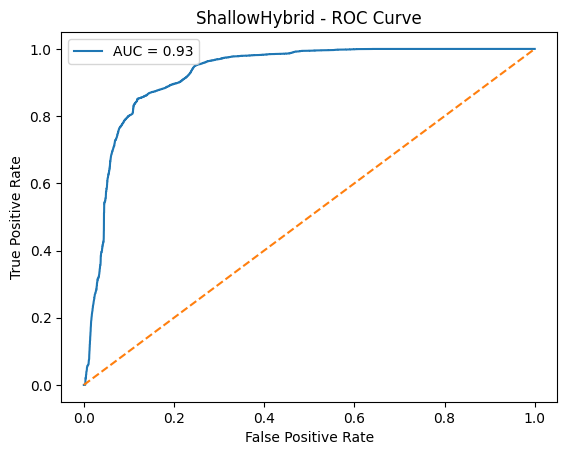

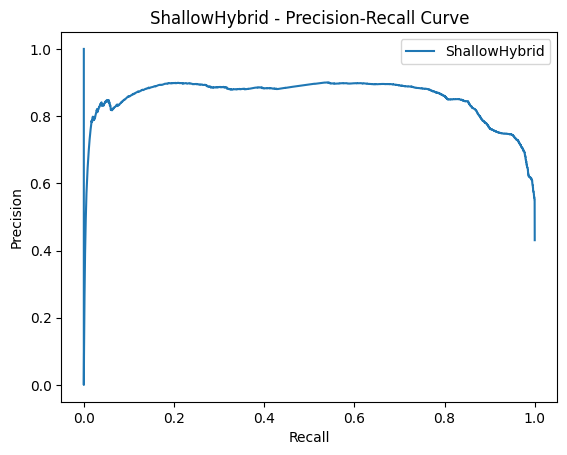


📌 DeepHybrid Classification Report:

              precision    recall  f1-score   support

         0.0       0.98      0.62      0.76     12833
         1.0       0.66      0.98      0.79      9711

    accuracy                           0.78     22544
   macro avg       0.82      0.80      0.78     22544
weighted avg       0.84      0.78      0.77     22544



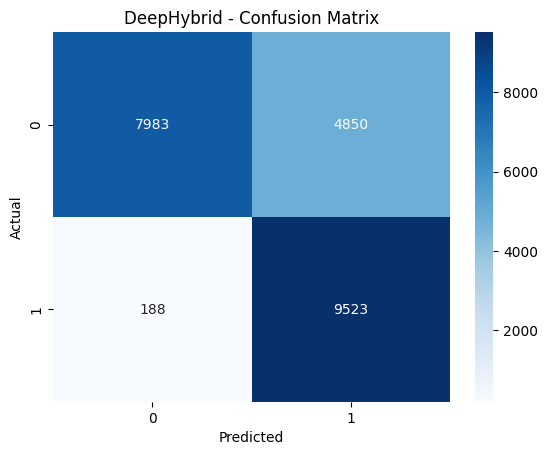

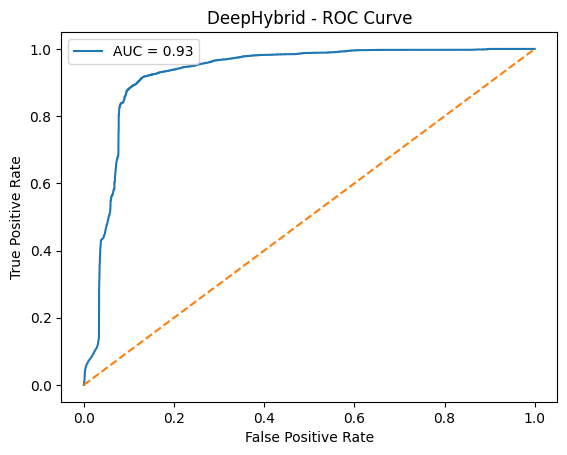

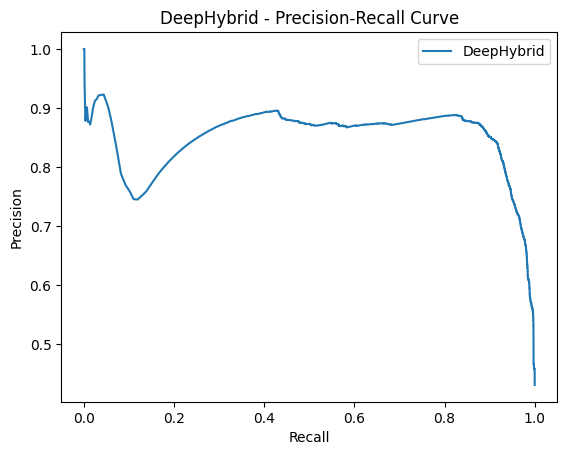


🕒 Training Time Summary:
ShallowCNN: 17.77 seconds
DeepCNN: 21.36 seconds
ShallowLSTM: 23.39 seconds
DeepLSTM: 27.49 seconds
ShallowHybrid: 27.00 seconds
DeepHybrid: 34.84 seconds


In [32]:
# 📊 Evaluate model performance
def evaluate_model(model, test_loader, model_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(yb.numpy())
    
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    y_pred_cls = (y_pred > 0.5).astype(int)

    print(f"\n📌 {model_name} Classification Report:\n")
    print(classification_report(y_true, y_pred_cls))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_cls)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(f"{model_name} - Confusion Matrix.png")
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1],[0,1],'--')
    plt.title(f"{model_name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.savefig(f"{model_name} - ROC Curve.png")
    plt.show()

    # Precision-Recall
    prec, rec, _ = precision_recall_curve(y_true, y_pred)
    plt.plot(rec, prec, label=f"{model_name}")
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.savefig(f"{model_name} - Precision-Recall Curve.png")
    plt.legend()
    plt.show()

# Run evaluation for each model
for name, model in trained_models.items():
    evaluate_model(model, test_loader, name)

# Print training times
print("\n🕒 Training Time Summary:")
for name, t in training_times.items():
    print(f"{name}: {t:.2f} seconds")


In [31]:
# ⚙️ Computational efficiency: training time, inference time, parameters, and model size
def compute_efficiency(model, name, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Params count
    total_params = sum(p.numel() for p in model.parameters())

    # Model size in MB
    model_path = f"temp_{name}.pt"
    torch.save(model.state_dict(), model_path)
    model_size = os.path.getsize(model_path) / 1e6  # in MB
    os.remove(model_path)

    # Inference time (on one batch)
    with torch.no_grad():
        start_inf = time.time()
        for xb, _ in test_loader:
            xb = xb.to(device)
            _ = model(xb)
            break  # only 1 batch
        end_inf = time.time()

    inference_time = end_inf - start_inf

    return {
        "Model": name,
        "Train Time (s)": training_times[name],
        "Inference Time (1 batch, s)": inference_time,
        "Params": total_params,
        "Size (MB)": round(model_size, 2)
    }

import os

# Collect metrics
efficiency_data = []
for name, model in trained_models.items():
    print(f"Computing efficiency for {name}...")
    metrics = compute_efficiency(model, name, test_loader)
    efficiency_data.append(metrics)

# Convert to DataFrame
eff_df = pd.DataFrame(efficiency_data)
display(eff_df)


Computing efficiency for ShallowCNN...
Computing efficiency for DeepCNN...
Computing efficiency for ShallowLSTM...
Computing efficiency for DeepLSTM...
Computing efficiency for ShallowHybrid...
Computing efficiency for DeepHybrid...


,Model,Train Time (s),"Inference Time (1 batch, s)",Params,Size (MB)
0,ShallowCNN,17.773467,0.001112,721,0.01
1,DeepCNN,21.364700,0.001217,6401,0.03
2,ShallowLSTM,23.385064,0.000752,9633,0.04
3,DeepLSTM,27.487986,0.000702,60737,0.25
4,ShallowHybrid,27.004627,0.000736,6497,0.03
5,DeepHybrid,34.840346,0.000902,72961,0.30
